# Supervised Machine Learning - Loan Prediction (Default Risk)

# Import & Data Loading

In [10]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
#to see graphs in the same jupyter notebook
%matplotlib inline
loan = pd.read_csv('Training Data.csv')
loan.head()

Id   Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
0   1  1303834   23           3         single          rented            no   
1   2  7574516   40          10         single          rented            no   
2   3  3991815   66           4        married          rented            no   
3   4  6256451   41           2         single          rented           yes   
4   5  5768871   47          11         single          rented            no   

            Profession                 CITY           STATE  CURRENT_JOB_YRS  \
0  Mechanical_engineer                 Rewa  Madhya_Pradesh                3   
1   Software_Developer             Parbhani     Maharashtra                9   
2     Technical_writer            Alappuzha          Kerala                4   
3   Software_Developer          Bhubaneswar          Odisha                2   
4        Civil_servant  Tiruchirappalli[10]      Tamil_Nadu                3   

   CURRENT_HOUSE_YRS  Risk_Flag  
0                 13          0  
1                 13          0  
2                 10          0  
3                 12          1  
4                 14          1

In [11]:
loan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [12]:
loan.describe()

Id        Income            Age     Experience  \
count  252000.000000  2.520000e+05  252000.000000  252000.000000   
mean   126000.500000  4.997117e+06      49.954071      10.084437   
std     72746.278255  2.878311e+06      17.063855       6.002590   
min         1.000000  1.031000e+04      21.000000       0.000000   
25%     63000.750000  2.503015e+06      35.000000       5.000000   
50%    126000.500000  5.000694e+06      50.000000      10.000000   
75%    189000.250000  7.477502e+06      65.000000      15.000000   
max    252000.000000  9.999938e+06      79.000000      20.000000   

       CURRENT_JOB_YRS  CURRENT_HOUSE_YRS      Risk_Flag  
count    252000.000000      252000.000000  252000.000000  
mean          6.333877          11.997794       0.123000  
std           3.647053           1.399037       0.328438  
min           0.000000          10.000000       0.000000  
25%           3.000000          11.000000       0.000000  
50%           6.000000          12.000000       0.000000  
75%           9.000000          13.000000       0.000000  
max          14.000000          14.000000       1.000000

### Exlporatory Data Analysis
1. How many have defaulted and How many have paid?

In [13]:
defaulted = len(loan.Risk_Flag[loan.Risk_Flag == 1])
Total = len(loan.Risk_Flag)
Rate_of_Risk = defaulted / Total 
print(f"Default Rate is {Rate_of_Risk*100}%")

Default Rate is 12.3%


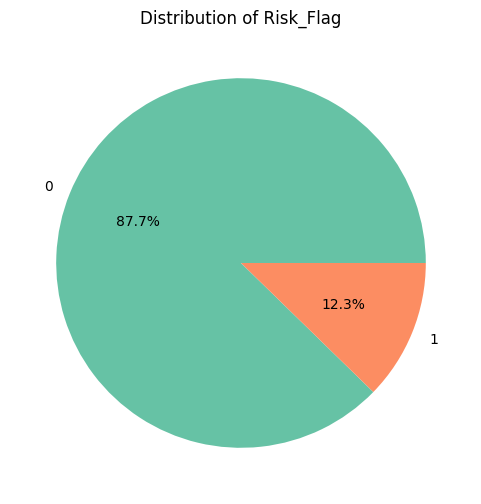

In [14]:
risk_flag_counts = loan['Risk_Flag'].value_counts()
# Set Seaborn's color palette
sns.set_palette("Set2")  # Set the color palette (optional)
# Plotting a pie chart using Matplotlib's plt.pie()
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(risk_flag_counts, labels=risk_flag_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Risk_Flag')
plt.show()

### Seems this is an imbalance data set to predict the default risk, first do some analytics and later optimize the model

## Categorical Features (Univariate & Bivariate  Analysis)

In [15]:
loan.rename(columns = {"Married/Single" : "Marital_status"},inplace=True)
loan.Marital_status.value_counts()

Marital_status
single     226272
married     25728
Name: count, dtype: int64

In [16]:
pivot_table = loan.pivot_table(index='Marital_status', columns='Risk_Flag', aggfunc='size', fill_value=0)
print(pivot_table)
loan.head()



Risk_Flag            0      1
Marital_status               
married          23092   2636
single          197912  28360


Id   Income  Age  Experience Marital_status House_Ownership Car_Ownership  \
0   1  1303834   23           3         single          rented            no   
1   2  7574516   40          10         single          rented            no   
2   3  3991815   66           4        married          rented            no   
3   4  6256451   41           2         single          rented           yes   
4   5  5768871   47          11         single          rented            no   

            Profession                 CITY           STATE  CURRENT_JOB_YRS  \
0  Mechanical_engineer                 Rewa  Madhya_Pradesh                3   
1   Software_Developer             Parbhani     Maharashtra                9   
2     Technical_writer            Alappuzha          Kerala                4   
3   Software_Developer          Bhubaneswar          Odisha                2   
4        Civil_servant  Tiruchirappalli[10]      Tamil_Nadu                3   

   CURRENT_HOUSE_YRS  Risk_Flag  
0                 13          0  
1                 13          0  
2                 10          0  
3                 12          1  
4                 14          1

<Figure size 640x480 with 0 Axes>

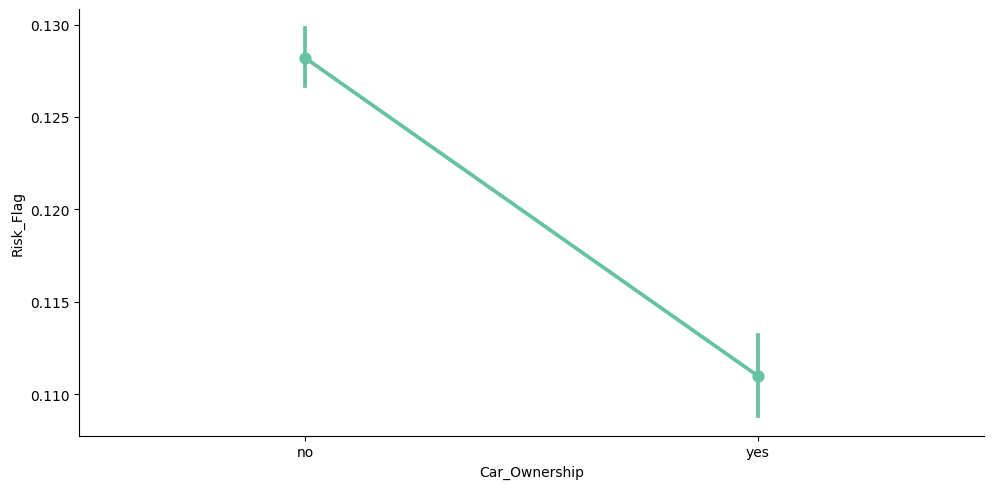

In [17]:
for i, col in enumerate(['Marital_status','House_Ownership', 'Car_Ownership']):
    plt.figure(i)
    sns.catplot(x=col, y='Risk_Flag', data=loan, kind='point', aspect=2, )

## Observation

1. Martial Status --> Singles are the highest loan takers and the highest default rate.
2. House_Ownership --> Rented people are high and have the highest default rate.
3. Car_Ownership --> people who dont have cars are the highest loan takers and the same time who has the highest default rate.

In [18]:
plt.subplots(figsize=(18,8))
loan.Profession.value_counts().plot.bar(color='green')
plt.show()

In [19]:
pivot_table = loan.pivot_table(index='Profession', columns='Risk_Flag', aggfunc='size', fill_value=0).sort_values(by=1, ascending=False).head()
print(pivot_table)


Risk_Flag                  0    1
Profession                       
Police_officer          4209  826
Software_Developer      4303  750
Air_traffic_controller  4566  715
Surveyor                4000  714
Physician               5247  710


#### Observation 
- According to the above observation we have highest loan takers are physicians and the loan default rates are under police officers

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a categorical plot using Seaborn's catplot
sns.catplot(x='Marital_status', y='Risk_Flag', hue='Car_Ownership', data=loan, kind='point')
plt.show()

- Here we can see both the singles who has a car and no car have the higest risks with respect to the married people

In [21]:
pivot_table = loan.pivot_table(index='STATE', columns='CITY', aggfunc='size', fill_value=0)
print(pivot_table)

CITY               Adoni  Agartala  Agra  Ahmedabad  Ahmednagar  Aizawl  \
STATE                                                                     
Andhra_Pradesh       953         0     0          0           0       0   
Assam                  0         0     0          0           0       0   
Bihar                  0         0     0          0           0       0   
Chandigarh             0         0     0          0           0       0   
Chhattisgarh           0         0     0          0           0       0   
Delhi                  0         0     0          0           0       0   
Gujarat                0         0     0        649           0       0   
Haryana                0         0     0          0           0       0   
Himachal_Pradesh       0         0     0          0           0       0   
Jammu_and_Kashmir      0         0     0          0           0       0   
Jharkhand              0         0     0          0           0       0   
Karnataka              0 

In [22]:
(pd.crosstab(loan.STATE, loan.Risk_Flag, margins=True)[1] / pd.crosstab(loan.STATE, loan.Risk_Flag, margins=True)["All"]).sort_values(ascending=False).head(10)

STATE
Manipur              0.215548
Tripura              0.168109
Kerala               0.167097
Jammu_and_Kashmir    0.158989
Madhya_Pradesh       0.154369
Odisha               0.142550
Rajasthan            0.140833
Jharkhand            0.133296
Chhattisgarh         0.133281
Himachal_Pradesh     0.133253
dtype: float64

- Manipur has the highest default rate, 21 %

In [23]:
pivot_table = loan.pivot_table(index='STATE', columns='Risk_Flag', aggfunc='size', fill_value=0).sort_values(by=1, ascending=False).head()
print(pivot_table)

Risk_Flag           0     1
STATE                      
Uttar_Pradesh   25057  3343
West_Bengal     20474  3009
Andhra_Pradesh  22362  2935
Maharashtra     22667  2895
Bihar           17197  2583


In [24]:
(pd.crosstab(loan.CITY, loan.Risk_Flag, margins=True)[1] / pd.crosstab(loan.CITY, loan.Risk_Flag, margins=True)["All"]).sort_values(ascending=False).head()

CITY
Bhubaneswar    0.326194
Gwalior        0.272727
Bettiah[33]    0.266958
Kochi          0.252862
Raiganj        0.239554
dtype: float64

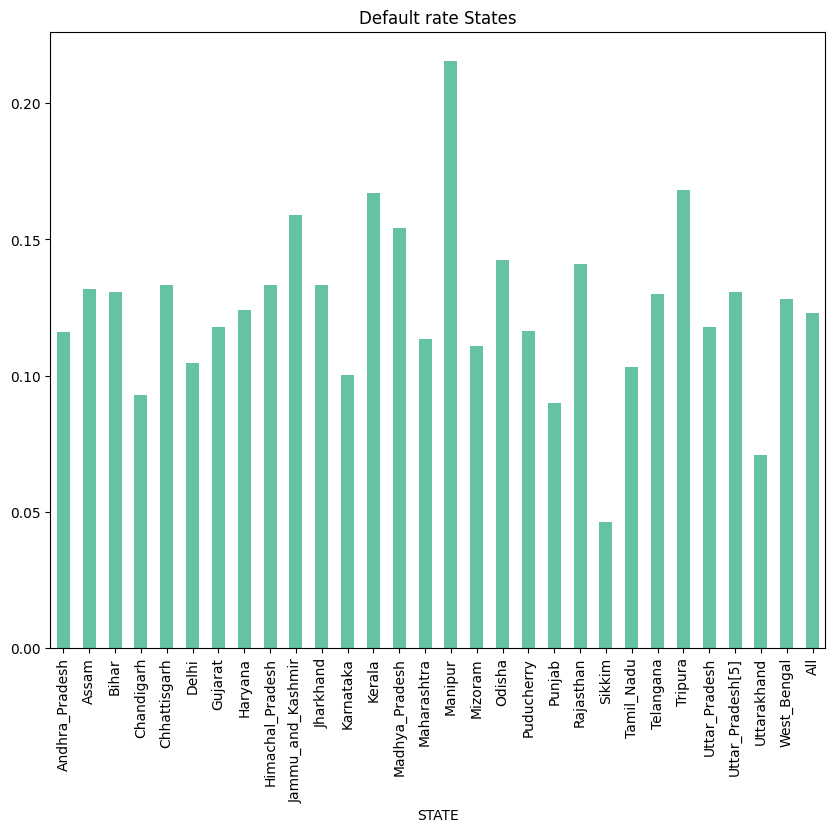

In [25]:
(pd.crosstab(loan.STATE, loan.Risk_Flag, margins=True)[1] / pd.crosstab(loan.STATE, loan.Risk_Flag, margins=True)["All"]).plot.bar().set(title="Default rate States")
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

- City -> Highest default rate was reported in Bhubaneswar (Odisha)
- State --> Highest default rate was reported in Manipur
- These two are mutually independent 
- Odisha doesnt have the highest default rate the sametime

## Continuous Data Exploration (Univariate & Bivariate  Analysis)

#### Income

In [26]:
loan.head()

Id   Income  Age  Experience Marital_status House_Ownership Car_Ownership  \
0   1  1303834   23           3         single          rented            no   
1   2  7574516   40          10         single          rented            no   
2   3  3991815   66           4        married          rented            no   
3   4  6256451   41           2         single          rented           yes   
4   5  5768871   47          11         single          rented            no   

            Profession                 CITY           STATE  CURRENT_JOB_YRS  \
0  Mechanical_engineer                 Rewa  Madhya_Pradesh                3   
1   Software_Developer             Parbhani     Maharashtra                9   
2     Technical_writer            Alappuzha          Kerala                4   
3   Software_Developer          Bhubaneswar          Odisha                2   
4        Civil_servant  Tiruchirappalli[10]      Tamil_Nadu                3   

   CURRENT_HOUSE_YRS  Risk_Flag  
0                 13          0  
1                 13          0  
2                 10          0  
3                 12          1  
4                 14          1

In [27]:
f , ax = plt.subplots(1,2,figsize=(18,8))
sns.histplot(loan.Income, ax=ax[1]);
sns.boxplot(loan.Income, ax=ax[0]);

In [28]:
pivot_table = loan.pivot_table(index='Income', columns='Risk_Flag', aggfunc='size', fill_value=0).sort_values(by=1, ascending=False).head()
print(pivot_table)

Risk_Flag  0   1
Income          
6715263    4  34
3424035    3  34
3154685    4  34
1362373    3  34
700444     4  34


- Income data shows the normality behaviour with no outliers as well

In [29]:
loan.Income.describe()

count    2.520000e+05
mean     4.997117e+06
std      2.878311e+06
min      1.031000e+04
25%      2.503015e+06
50%      5.000694e+06
75%      7.477502e+06
max      9.999938e+06
Name: Income, dtype: float64

In [30]:
pd.crosstab(loan.Profession ,loan.Income)

Income                      10310    10675    11114    11430    11483    \
Profession                                                                
Air_traffic_controller            0        0        0        0        0   
Analyst                           0        0        0        0        0   
Architect                         0        0        0        0        0   
Army_officer                      0        0        0        0        0   
Artist                            0        0        0        0        0   
Aviator                           0        0        0        0        0   
Biomedical_Engineer               0        0        0        0        0   
Chartered_Accountant              0        0        0        0        0   
Chef                              0        0        0        0        0   
Chemical_engineer                 0        0        0        0        0   
Civil_engineer                    0        0        0        0        0   
Civil_servant                     0        0        0       37        0   
Comedian                          0        0        0        0        0   
Computer_hardware_engineer        0        0        0        0        0   
Computer_operator                 0        0        0        0        0   
Consultant                        0        0        0        0        0   
Dentist                           0        0        0        0        0   
Design_Engineer                   0        0        0        0        0   
Designer                          0        0        0        0        0   
Drafter                           0        0        0        0        0   
Economist                         0        0        0        0        0   
Engineer                         37        0        0        0        1   
Fashion_Designer                  0        0        0        0        0   
Financial_Analyst                 0        0        0        0        0   
Firefighter                       0        0        0        0        0   
Flight_attendant                  0        0        0        0        0   
Geologist                         0        0        0        0        0   
Graphic_Designer                  0       37        0        0        0   
Hotel_Manager                     0        0        0        0        0   
Industrial_Engineer               0        0        0        0        0   
Lawyer                            0        0        0        0        0   
Librarian                         0        0        0        0        0   
Magistrate                        0        0        0        0        0   
Mechanical_engineer               0        0        0        0        0   
Microbiologist                    0        0        0        0        0   
Official                          0        0        0        0        0   
Petroleum_Engineer                0        0        0        0        0   
Physician                         0        0        0        0        0   
Police_officer                    0        0        0        0        0   
Politician                        0        0        0        0        0   
Psychologist                      0        0        0        0        0   
Scientist                         0        0        0        0        0   
Secretary                         0        0        0        0        0   
Software_Developer                0        0        0        0        0   
Statistician                      0        0        0        0        0   
Surgeon                           0        0        0        0        0   
Surveyor                          0        0       36        0        0   
Technical_writer                  0        0        0        0        0   
Technician                        0        0        0        0        0   
Technology_specialist             0        0        0        0        0   
Web_designer                      0        0        0        0        0   

Income                  

#### Age

In [31]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.distplot(loan.Age, ax=ax[1])
sns.boxenplot(y=loan.Age, ax=ax[0], orient='h')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3104\2854913100.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loan.Age, ax=ax[1])
c:\ProgramData\anaconda3\envs\mlproj\lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


In [32]:
pivot_table = loan.pivot_table(index='Age', columns='Risk_Flag', aggfunc='size', fill_value=0).sort_values(by=1, ascending=False).head(15)
print(pivot_table)

Risk_Flag     0    1
Age                 
22         3660  770
66         4355  737
27         4477  720
33         4202  719
26         3437  719
76         3919  666
54         4125  660
24         3695  631
47         3867  616
28         3299  602
21         3607  598
59         3907  591
30         3879  589
45         4217  589
25         3959  584


-  The oldest age is 79, the youngest is 21, and the average age is 49. Also, the box plot indicates that the density is higher between 35 and 65, indicating that this range receives the majority of loans.

In [33]:
sns.catplot(x='Experience', y='Risk_Flag', data=loan, kind='point',aspect=2)
plt.title('Risk_Flag vs Experience')

Text(0.5, 1.0, 'Risk_Flag vs Experience')

- We can see we are now having the down trend with the experience so we can say, people with less experience have more risk in taking loan.

<Figure size 640x480 with 0 Axes>

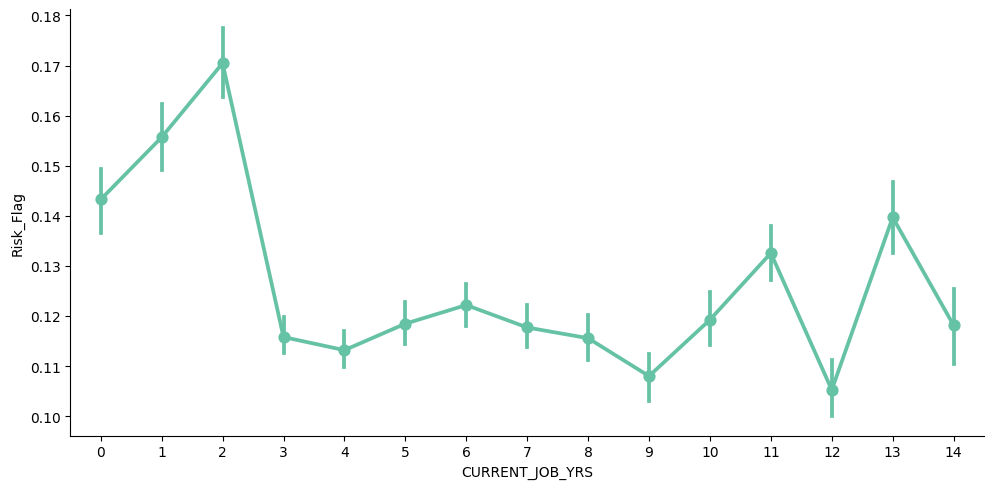

In [34]:
for i, col in enumerate(['CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']):
    plt.figure(i)
    sns.catplot(x=col, y='Risk_Flag', data=loan, kind='point', aspect=2, )

- People who has less current job years have the high risk of loan paying back, also after two years there is drastic different and downtrend continuous with slight variations.

- Current House Years shows the complete down trend and after 10 they have the ability to payback rate is high that means low risk.

## Feature Engineering 

### Income_Band from Income

In [35]:
loan["Income_band"] = 0
loan.loc[(loan["Income"] > 0) & (loan["Income"] <= 1000000), "Income_band"] = 1
loan.loc[(loan["Income"] > 1000000) & (loan["Income"] <= 2000000), "Income_band"] = 2
loan.loc[(loan["Income"] > 2000000) & (loan["Income"] <= 3000000), "Income_band"] = 3
loan.loc[(loan["Income"] > 3000000) & (loan["Income"] <= 4000000), "Income_band"] = 4
loan.loc[(loan["Income"] > 4000000) & (loan["Income"] <= 5000000), "Income_band"] = 5
loan.loc[(loan["Income"] > 5000000) & (loan["Income"] <= 6000000), "Income_band"] = 6
loan.loc[(loan["Income"] > 6000000) & (loan["Income"] <= 7000000), "Income_band"] = 7
loan.loc[(loan["Income"] > 7000000) & (loan["Income"] <= 8000000), "Income_band"] = 8
loan.loc[(loan["Income"] > 8000000) & (loan["Income"] <= 9000000), "Income_band"] = 9
loan.loc[(loan["Income"] > 9000000) & (loan["Income"] <= 10000000), "Income_band"] = 10


In [36]:
loan["Income_band"].value_counts().to_frame().style.background_gradient(cmap='viridis')

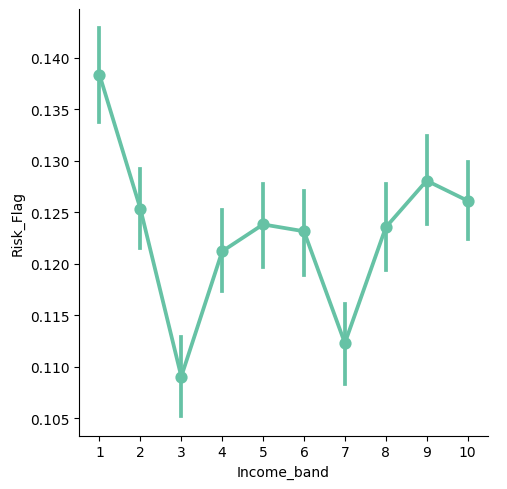

In [37]:
sns.catplot(x='Income_band',y='Risk_Flag', data=loan,kind='point');

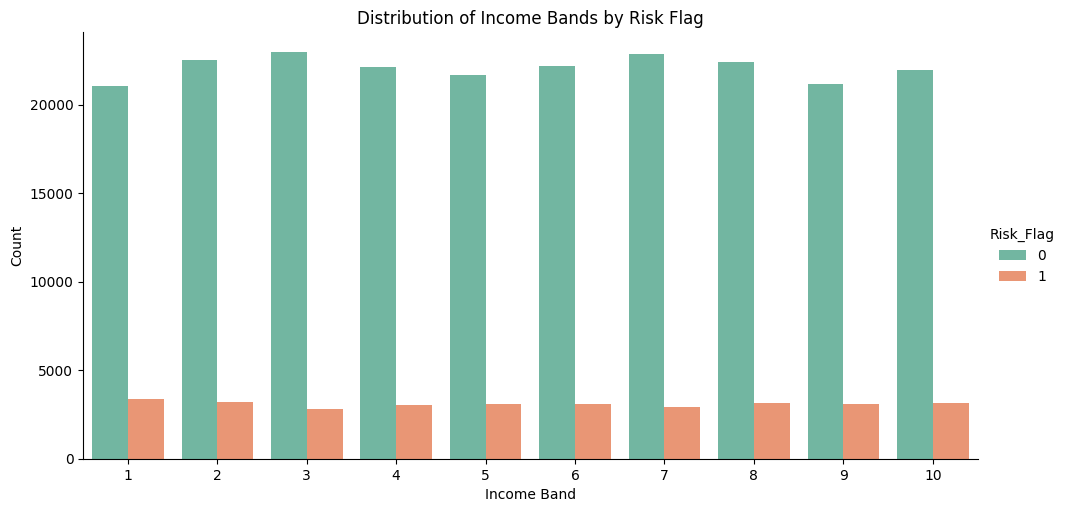

In [38]:
sns.catplot(data=loan, x='Income_band', hue='Risk_Flag', kind='count', aspect=2,)
plt.xlabel('Income Band')
plt.ylabel('Count')
plt.title('Distribution of Income Bands by Risk Flag')
plt.show()


### Age_band from Age

In [39]:
loan["Age_band"] = 0
loan.loc[(loan["Age"] >= 21) & (loan["Age"] <= 33), "Age_band"] = 0
loan.loc[(loan["Age"] > 33) & (loan["Age"] <= 45), "Age_band"] = 1
loan.loc[(loan["Age"] > 45) & (loan["Age"] <= 57), "Age_band"] = 2
loan.loc[(loan["Age"] > 57) & (loan["Age"] <= 69), "Age_band"] = 3
loan.loc[(loan["Age"] > 69) & (loan["Age"] <= 79), "Age_band"] = 4

In [40]:
loan["Age_band"].value_counts().to_frame().style.background_gradient(cmap='viridis')

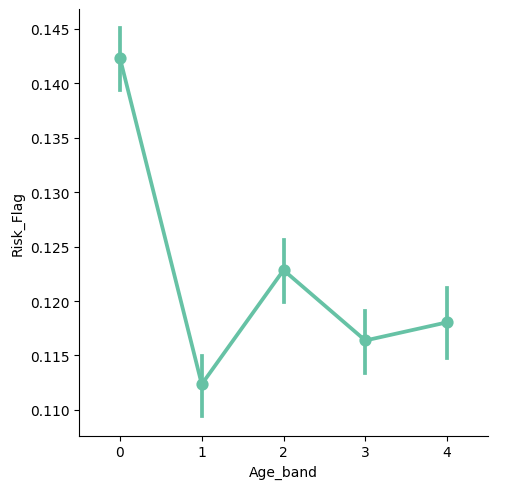

In [41]:
sns.catplot(x='Age_band',y='Risk_Flag', data=loan,kind='point');

In [42]:
sns.catplot(x='Income_band',y='Risk_Flag', data=loan, hue="Car_Ownership",kind='point')

- Income band 5 with car and without car shows drastic different also in high income band without a car has a high default risk and thats bit unrealistic.
- Downtrend continues in risk till income band 3 and 5 without a car and with a car. 

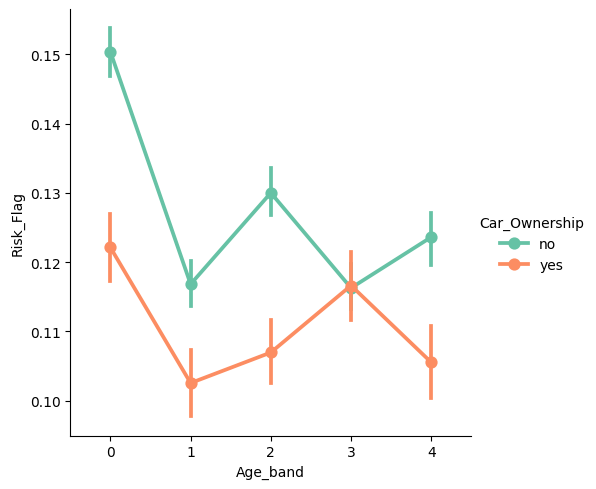

In [43]:
sns.catplot(x='Age_band',y='Risk_Flag', data=loan, hue="Car_Ownership",kind='point')

- Having a car shows a low risk rather than without a car even under the high age limit

#### Creating a new feature and remove multicolinearity

- EXPERIENCE and CURRENT_JOB_YRS = Total Experience

In [44]:
loan['Total_EXP']=loan['Experience']+loan['CURRENT_JOB_YRS']
sns.catplot(x='Total_EXP',y='Risk_Flag',data=loan,kind='point',aspect=2,)

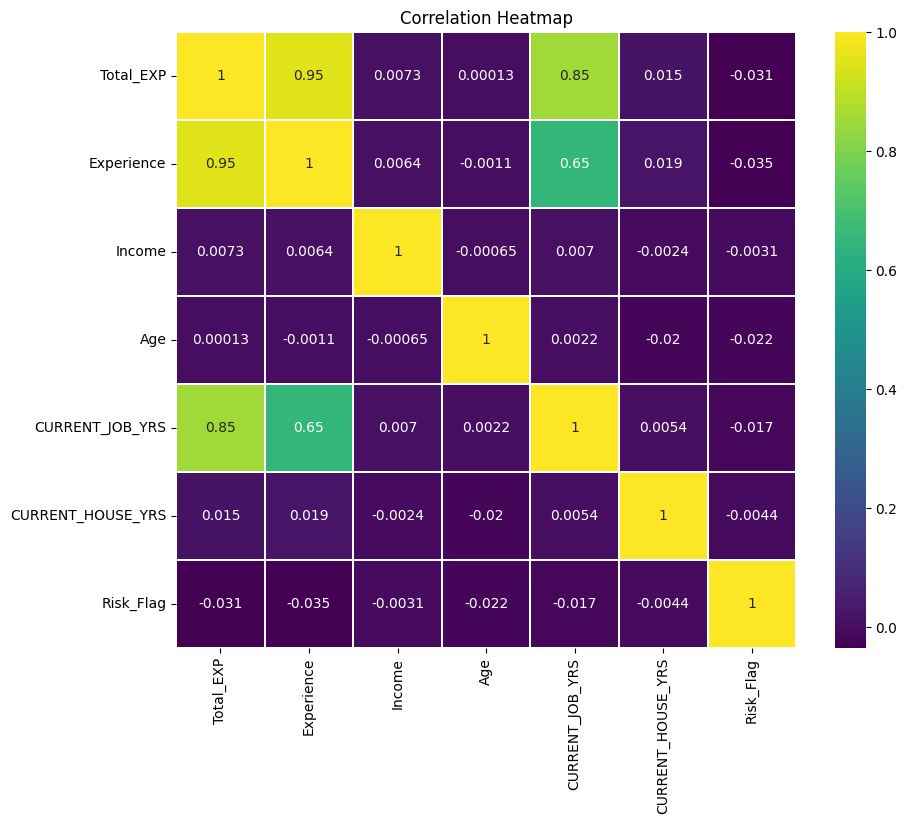

In [45]:
cols_to_correlate = ['Total_EXP','Experience','Income','Age','CURRENT_JOB_YRS','CURRENT_HOUSE_YRS','Risk_Flag']

correlation_matrix = loan[cols_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", linewidths=0.2)
plt.title('Correlation Heatmap')
plt.show()

- Creation of the new feature make sense as shown in the heatmap as well, by removing multicolinearity we can feed the feature into the model.

## Dropping the Features

In [46]:
loan.drop(["Id", "Income", "Income_band", "Age", "Experience","CURRENT_JOB_YRS",], axis=1, inplace=True)

In [47]:
loan.head()

Marital_status House_Ownership Car_Ownership           Profession  \
0         single          rented            no  Mechanical_engineer   
1         single          rented            no   Software_Developer   
2        married          rented            no     Technical_writer   
3         single          rented           yes   Software_Developer   
4         single          rented            no        Civil_servant   

                  CITY           STATE  CURRENT_HOUSE_YRS  Risk_Flag  \
0                 Rewa  Madhya_Pradesh                 13          0   
1             Parbhani     Maharashtra                 13          0   
2            Alappuzha          Kerala                 10          0   
3          Bhubaneswar          Odisha                 12          1   
4  Tiruchirappalli[10]      Tamil_Nadu                 14          1   

   Age_band  Total_EXP  
0         0          6  
1         1         19  
2         3          8  
3         1          4  
4         2         14

### Encoding Categorical Variables

In [48]:
from sklearn.preprocessing import LabelEncoder

features = ["Marital_status", "House_Ownership", "Car_Ownership", "Profession","CITY", "STATE",]
label_encoder = LabelEncoder()

for col in features:
    loan[col] = label_encoder.fit_transform(loan[col])

In [49]:
loan.head()

Marital_status  House_Ownership  Car_Ownership  Profession  CITY  STATE  \
0               1                2              0          33   251     13   
1               1                2              0          43   227     14   
2               0                2              0          47     8     12   
3               1                2              1          43    54     17   
4               1                2              0          11   296     22   

   CURRENT_HOUSE_YRS  Risk_Flag  Age_band  Total_EXP  
0                 13          0         0          6  
1                 13          0         1         19  
2                 10          0         3          8  
3                 12          1         1          4  
4                 14          1         2         14

In [50]:
loan.to_csv('transformed.csv',index=False)

In [56]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Marital_status     252000 non-null  int32
 1   House_Ownership    252000 non-null  int32
 2   Car_Ownership      252000 non-null  int32
 3   Profession         252000 non-null  int32
 4   CITY               252000 non-null  int32
 5   STATE              252000 non-null  int32
 6   CURRENT_HOUSE_YRS  252000 non-null  int64
 7   Risk_Flag          252000 non-null  int64
 8   Age_band           252000 non-null  int64
 9   Total_EXP          252000 non-null  int64
dtypes: int32(6), int64(4)
memory usage: 13.5 MB


In [51]:
sns.heatmap(loan.corr(), annot=True, linewidth=0.2, annot_kws={"size":15}, cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### There is no high corelation shown with the input fetaures to the output Risk Flag ,  will optimize later after implementing the model

# Modelling 

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

features = loan.drop('Risk_Flag',axis=1)
labels = loan ['Risk_Flag']
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.4,random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=42)

for dataset in (y_train,y_val,y_test):
        print(round(len(dataset)/len(labels),2))


0.6
0.2
0.2


#### Write out divided data into CSV

In [53]:
x_train.to_csv('train_features.csv',index=False)
x_val.to_csv('val_features.csv',index=False)
x_test.to_csv('test_features.csv',index=False)

y_train.to_csv('train_labels.csv',index=False)
y_val.to_csv('val_labels.csv',index=False)
y_test.to_csv('test_lables.csv',index=False)

#### Cross Validation - RandomForestClassifier

In [54]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

rf = RandomForestClassifier()
scores = cross_val_score(rf,tr_features,tr_labels.values.ravel(),cv=5)
print(scores)

KeyboardInterrupt: 

#### Cross Validation - Decision Tree

In [ ]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

dt = DecisionTreeClassifier()
scores = cross_val_score(dt,tr_features,tr_labels.values.ravel(),cv=5)
print(scores)

[0.8827381  0.88115079 0.87946429 0.88101852 0.88025794]


### Tune Hyperparameters - RandomForestClassifier

In [ ]:
#Finding the results of every hyperparameter combination about the average accuracy score across the five folds and the STD across the same.
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
rf = RandomForestClassifier()
parameters = {'n_estimators':[5,50,100], 'max_depth':[2,10,20,None]}
cv=GridSearchCV(rf,parameters,cv=5)
cv.fit(tr_features,tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 100}

0.877 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.877 (+/-0.0) for {'max_depth': 2, 'n_estimators': 50}
0.877 (+/-0.0) for {'max_depth': 2, 'n_estimators': 100}
0.878 (+/-0.0) for {'max_depth': 10, 'n_estimators': 5}
0.878 (+/-0.0) for {'max_depth': 10, 'n_estimators': 50}
0.878 (+/-0.001) for {'max_depth': 10, 'n_estimators': 100}
0.892 (+/-0.001) for {'max_depth': 20, 'n_estimators': 5}
0.895 (+/-0.003) for {'max_depth': 20, 'n_estimators': 50}
0.895 (+/-0.003) for {'max_depth': 20, 'n_estimators': 100}
0.893 (+/-0.003) for {'max_depth': None, 'n_estimators': 5}
0.898 (+/-0.004) for {'max_depth': None, 'n_estimators': 50}
0.898 (+/-0.003) for {'max_depth': None, 'n_estimators': 100}


### Tune Hyperparameters - Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
parameters = {
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']}
cv=GridSearchCV(rf,parameters,cv=5)
cv.fit(tr_features,tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
0.877 (+/-0.0) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf':

### Evaluating the Selected Models

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

val_features = pd.read_csv('val_features.csv') # Validation set to make the first prediction
val_labels = pd.read_csv('val_labels.csv')

te_features = pd.read_csv('test_features.csv') # Test we use as a double confirmation to the result from validation data set.
te_label = pd.read_csv('test_lables.csv')

In [ ]:
#Refit on the full training set? yes, cz in five fold CV we test 80% of data in eachloop thats why.
rf1=RandomForestClassifier(n_estimators=50,max_depth=20)
rf1.fit(tr_features,tr_labels.values.ravel())
rf2=RandomForestClassifier(n_estimators=50,max_depth=None)
rf2.fit(tr_features,tr_labels.values.ravel())

RandomForestClassifier(n_estimators=50)

In [ ]:
dtc1 = DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features='log2', min_samples_leaf=2, min_samples_split=10)
dtc1.fit(tr_features,tr_labels.values.ravel())
dtc2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features='log2', min_samples_leaf=2, min_samples_split=5)
dtc2.fit(tr_features,tr_labels.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, min_samples_split=5)

#### Random Forest Classifier Model Evaluation Metrics on Validation Set

In [ ]:
for mdl in [rf1,rf2]:
    y_pred = mdl.predict(val_features)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 20 / # OF EST: 50 -- A: 0.896 / P: 0.62 / R: 0.416
MAX DEPTH: None / # OF EST: 50 -- A: 0.899 / P: 0.6 / R: 0.554


- Accuracy: Overall, how often the model is correct
- Precision: The proportion of correctly predicted positive cases among all predicted positive cases
- Recall (Sensitivity): The proportion of correctly predicted positive cases among all actual positive cases

#### Decision Tree Model Evaluation Metrics on Validation Set

In [ ]:
for mdl in [dtc1, dtc2]:
    y_pred = mdl.predict(val_features)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / MIN_SAMPLES_SPLIT: {} / MIN_SAMPLES_LEAF: {} / MAX_FEATURES: {} / CRITERION: {} -- A: {} / P: {} / R: {}'.format(
        mdl.max_depth,
        mdl.min_samples_split,
        mdl.min_samples_leaf,
        mdl.max_features,
        mdl.criterion,
        accuracy,
        precision,
        recall))

MAX DEPTH: None / MIN_SAMPLES_SPLIT: 10 / MIN_SAMPLES_LEAF: 2 / MAX_FEATURES: log2 / CRITERION: entropy -- A: 0.889 / P: 0.553 / R: 0.545
MAX DEPTH: None / MIN_SAMPLES_SPLIT: 5 / MIN_SAMPLES_LEAF: 2 / MAX_FEATURES: log2 / CRITERION: entropy -- A: 0.89 / P: 0.554 / R: 0.559


#### Confusion Matrix on the Selected Models

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming val_features and val_labels are your validation features and labels

# Make cross-validated predictions
y_pred = cross_val_predict(RandomForestClassifier(max_depth=None, n_estimators=50), val_features, val_labels.values.ravel(), cv=5)

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='2.0f')
plt.title("RandomForest confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 'rf2' selected randomforest classifier - Just modelling and not a good model
 - Since we need correctly to predict risk_flag = 1 , we need to optimize the model aligning with the confusion matrix of Recall(High True Positive Rate)

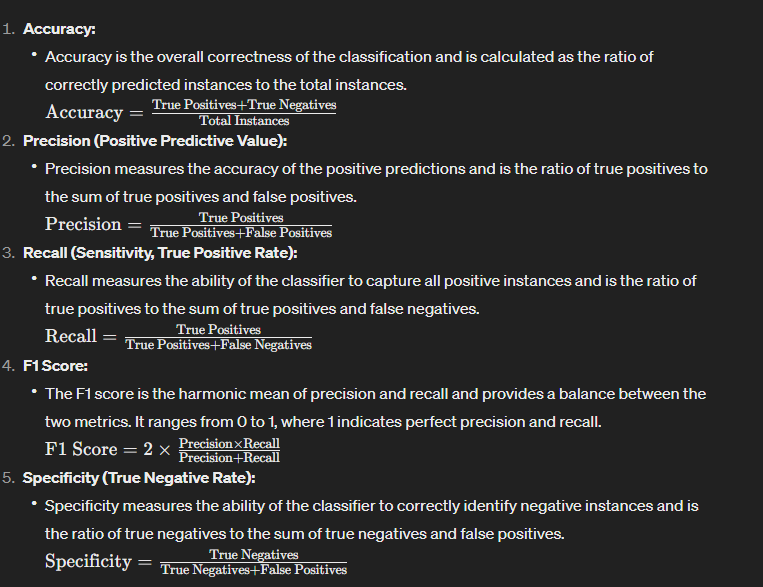

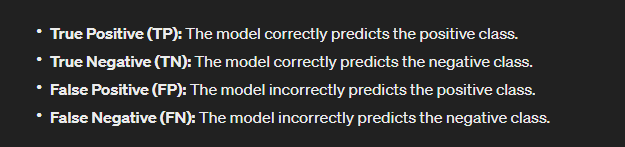